# Training Spectra Analysis: Sequential2D Weight Matrices

This notebook analyzes the singular value spectra of weight matrices during training for two Sequential2D architectures:

1. **Diagonal Architecture**: A simple sequential chain where data flows through blocks along the diagonal
2. **Full Architecture**: A more complex architecture where data can flow through multiple parallel paths

## Problem: Vector Length Prediction

Given a random vector $\mathbf{x}$, predict its L2 norm (length): $y = \|\mathbf{x}\|_2$

This simple regression problem allows us to focus on understanding how weight matrix spectra evolve during training.

## Learning Objectives

- Understand how singular values of weight matrices change during training
- Compare spectral evolution in different Sequential2D architectures
- Gain insights into the learning dynamics of 2D block architectures

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from iterativennsimple.Sequential2D import Sequential2D
from iterativennsimple.Sequential1D import Sequential1D
from iterativennsimple.MaskedLinear import MaskedLinear

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Generation

Create synthetic data where the task is to predict the L2 norm of input vectors.

In [2]:
def generate_data(n_samples, input_size):
    """
    Generate random vectors and their L2 norms
    
    Args:
        n_samples: Number of samples to generate
        input_size: Dimensionality of input vectors
        
    Returns:
        X: Input vectors of shape (n_samples, input_size)
        y: L2 norms of shape (n_samples, 1)
    """
    X = torch.randn(n_samples, input_size)
    y = torch.norm(X, dim=1, keepdim=True)
    return X, y

# Generate training and test data
n_train = 1000
n_test = 200
input_size = 20
hidden_size = 15
output_size = 1

X_train, y_train = generate_data(n_train, input_size)
X_test, y_test = generate_data(n_test, input_size)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")
print(f"\nSample input norm: {y_train[0].item():.4f}")

Training data shape: X=torch.Size([1000, 20]), y=torch.Size([1000, 1])
Test data shape: X=torch.Size([200, 20]), y=torch.Size([200, 1])

Sample input norm: 5.1300


## Model 1: Diagonal Sequential2D Architecture

This architecture has a simple sequential structure where data flows through blocks along the diagonal:

$$
\begin{bmatrix}
\text{None} & F_1 & \text{None} & \text{None} \\
\text{None} & \text{None} & F_2 & \text{None} \\
\text{None} & \text{None} & \text{None} & F_3 \\
\text{None} & \text{None} & \text{None} & \text{None}
\end{bmatrix}
$$

Where:
- $F_1$: Linear transformation from input to hidden space
- $F_2$: ReLU + Linear transformation in hidden space  
- $F_3$: ReLU + Linear transformation to output space

In [3]:
def create_diagonal_model():
    """
    Create a Sequential2D model with diagonal structure
    
    Returns:
        model: Sequential2D model
        blocks_list: List of (name, block) tuples for analysis
    """
    # Create the three blocks
    F1 = Sequential1D(
        nn.Sequential(MaskedLinear(input_size, hidden_size)),
        in_features=input_size, 
        out_features=hidden_size
    )
    
    F2 = Sequential1D(
        nn.Sequential(nn.ReLU(), MaskedLinear(hidden_size, hidden_size)),
        in_features=hidden_size, 
        out_features=hidden_size
    )
    
    F3 = Sequential1D(
        nn.Sequential(nn.ReLU(), MaskedLinear(hidden_size, output_size)),
        in_features=hidden_size, 
        out_features=output_size
    )
    
    # Diagonal block structure
    blocks = [
        [None, F1, None, None],
        [None, None, F2, None],
        [None, None, None, F3],
        [None, None, None, None]
    ]
    
    # Dimensions at each step
    in_features_list = [input_size, hidden_size, hidden_size, output_size]
    out_features_list = [input_size, hidden_size, hidden_size, output_size]
    
    # Create model
    model = Sequential2D(in_features_list, out_features_list, blocks)
    
    # Store block references for analysis
    blocks_list = [
        ("F1", F1),
        ("F2", F2),
        ("F3", F3)
    ]
    
    return model, blocks_list

diagonal_model, diagonal_blocks = create_diagonal_model()
print(f"Diagonal model parameters: {sum(p.numel() for p in diagonal_model.parameters())}")

Diagonal model parameters: 1651


## Model 2: Full Sequential2D Architecture

This architecture allows data to flow through multiple parallel paths:

$$
\begin{bmatrix}
\text{None} & G_{01} & G_{02} & G_{03} \\
\text{None} & G_{11} & G_{12} & G_{13} \\
\text{None} & G_{21} & G_{22} & G_{23} \\
\text{None} & G_{31} & G_{32} & G_{33}
\end{bmatrix}
$$

Each $G_{ij}$ is a linear transformation, creating a richer connectivity pattern.

In [4]:
def create_full_model():
    """
    Create a Sequential2D model with full structure (all non-None blocks in upper triangle)
    
    Returns:
        model: Sequential2D model
        blocks_dict: Dictionary of (name, block) for analysis
    """
    # Create all blocks - varying sizes to match architecture
    blocks_dict = {}
    G_blocks = [[None, None, None, None] for _ in range(4)]
    
    # Define dimensions for each layer
    # Layer 0: input_size, Layer 1-2: hidden_size, Layer 3: output_size
    layer_dims = [input_size, hidden_size, hidden_size, output_size]
    
    for i in range(4):
        for j in range(i+1, 4):
            name = f"G{i}{j}"
            block = Sequential1D(
                nn.Sequential(MaskedLinear(layer_dims[i], layer_dims[j])),
                in_features=layer_dims[i],
                out_features=layer_dims[j]
            )
            G_blocks[i][j] = block
            blocks_dict[name] = block
    
    # Dimensions at each step - properly sized to match layer transitions
    in_features_list = [input_size, hidden_size, hidden_size, output_size]
    out_features_list = [input_size, hidden_size, hidden_size, output_size]
    
    # Create model
    model = Sequential2D(in_features_list, out_features_list, G_blocks)
    
    # Wrap with forward function that handles iteration
    class FullModel(nn.Module):
        def __init__(self, seq2d):
            super().__init__()
            self.seq2d = seq2d
            
        def forward(self, x):
            # Initialize state
            state = [x, None, None, None]
            # Iterate 3 times
            for _ in range(3):
                state = self.seq2d(state)
            # Return final state
            return state[3]
    
    wrapped_model = FullModel(model)
    
    return wrapped_model, blocks_dict

full_model, full_blocks = create_full_model()
print(f"Full model parameters: {sum(p.numel() for p in full_model.parameters())}")

Full model parameters: 2673


## Singular Value Extraction Function

Extract singular values from MaskedLinear weight matrices within each block.

In [5]:
def get_singular_values(block):
    """
    Extract singular values from the MaskedLinear layer in a Sequential1D block
    
    Args:
        block: Sequential1D containing layers
        
    Returns:
        Singular values as numpy array, or None if no MaskedLinear found
    """
    # Iterate through the sequential block to find MaskedLinear
    for module in block:
        if isinstance(module, MaskedLinear):
            # Get the weight matrix
            weight = module.weight.data.cpu().numpy()
            # Compute SVD
            _, s, _ = np.linalg.svd(weight, full_matrices=False)
            return s
    return None

# Test extraction on diagonal model
test_sv = get_singular_values(diagonal_blocks[0][1])
if test_sv is not None:
    print(f"Successfully extracted {len(test_sv)} singular values from F1")
    print(f"Top 5 singular values: {test_sv[:5]}")

## Training Function with Spectral Tracking

Train models while recording singular value spectra at regular intervals.

In [6]:
def train_with_spectral_tracking(model, blocks_info, X_train, y_train, X_test, y_test, 
                                  n_epochs=500, lr=0.01, record_interval=50, n_iterations=3):
    """
    Train model and track singular value spectra
    
    Args:
        model: The model to train
        blocks_info: List or dict of (name, block) for spectral analysis
        X_train, y_train: Training data
        X_test, y_test: Test data
        n_epochs: Number of training epochs
        lr: Learning rate
        record_interval: Record spectra every N epochs
        n_iterations: Number of iterations for Sequential2D forward pass
        
    Returns:
        train_losses: Training loss history
        test_losses: Test loss history
        spectra_history: Dictionary mapping block names to list of spectra over time
        epochs_recorded: List of epochs when spectra were recorded
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    spectra_history = {}
    epochs_recorded = []
    
    # Initialize spectra history for each block
    if isinstance(blocks_info, dict):
        block_items = blocks_info.items()
    else:
        block_items = blocks_info
        
    for name, _ in block_items:
        spectra_history[name] = []
    
    print(f"Training for {n_epochs} epochs...")
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass depends on model type
        if hasattr(model, 'seq2d'):
            # Full model with Sequential2D wrapper
            output = model(X_train)
        else:
            # Direct Sequential2D model
            state = [X_train, None, None, None]
            for _ in range(n_iterations):
                state = model(state)
            output = state[3]
        
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            if hasattr(model, 'seq2d'):
                test_output = model(X_test)
            else:
                state = [X_test, None, None, None]
                for _ in range(n_iterations):
                    state = model(state)
                test_output = state[3]
            
            test_loss = criterion(test_output, y_test)
            test_losses.append(test_loss.item())
        
        # Record spectra at intervals
        if epoch % record_interval == 0:
            epochs_recorded.append(epoch)
            for name, block in block_items:
                sv = get_singular_values(block)
                if sv is not None:
                    spectra_history[name].append(sv)
            
            if epoch % (record_interval * 2) == 0:
                print(f"Epoch {epoch}/{n_epochs} - Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    
    print(f"Final - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
    
    return train_losses, test_losses, spectra_history, epochs_recorded

## Train Diagonal Model

In [7]:
print("="*60)
print("Training Diagonal Model")
print("="*60)

diag_train_loss, diag_test_loss, diag_spectra, diag_epochs = train_with_spectral_tracking(
    diagonal_model, diagonal_blocks, X_train, y_train, X_test, y_test,
    n_epochs=500, lr=0.01, record_interval=50
)

Training Diagonal Model
Training for 500 epochs...
Epoch 0/500 - Train Loss: 16.2714, Test Loss: 15.6317
Epoch 100/500 - Train Loss: 0.1428, Test Loss: 0.2361
Training for 500 epochs...
Epoch 0/500 - Train Loss: 16.2714, Test Loss: 15.6317
Epoch 100/500 - Train Loss: 0.1428, Test Loss: 0.2361
Epoch 200/500 - Train Loss: 0.0951, Test Loss: 0.2064
Epoch 300/500 - Train Loss: 0.0811, Test Loss: 0.1986
Epoch 200/500 - Train Loss: 0.0951, Test Loss: 0.2064
Epoch 300/500 - Train Loss: 0.0811, Test Loss: 0.1986
Epoch 400/500 - Train Loss: 0.0723, Test Loss: 0.1894
Final - Train Loss: 0.0668, Test Loss: 0.1791
Epoch 400/500 - Train Loss: 0.0723, Test Loss: 0.1894
Final - Train Loss: 0.0668, Test Loss: 0.1791


## Train Full Model

In [8]:
print("="*60)
print("Training Full Model")
print("="*60)

full_train_loss, full_test_loss, full_spectra, full_epochs = train_with_spectral_tracking(
    full_model, full_blocks, X_train, y_train, X_test, y_test,
    n_epochs=500, lr=0.01, record_interval=50
)

Training Full Model
Training for 500 epochs...
Epoch 0/500 - Train Loss: 20.9266, Test Loss: 20.5329
Epoch 100/500 - Train Loss: 0.4612, Test Loss: 0.4769
Epoch 100/500 - Train Loss: 0.4612, Test Loss: 0.4769
Epoch 200/500 - Train Loss: 0.4611, Test Loss: 0.4773
Epoch 200/500 - Train Loss: 0.4611, Test Loss: 0.4773
Epoch 300/500 - Train Loss: 0.4611, Test Loss: 0.4779
Epoch 300/500 - Train Loss: 0.4611, Test Loss: 0.4779
Epoch 400/500 - Train Loss: 0.4613, Test Loss: 0.4766
Epoch 400/500 - Train Loss: 0.4613, Test Loss: 0.4766
Final - Train Loss: 0.4611, Test Loss: 0.4772
Final - Train Loss: 0.4611, Test Loss: 0.4772


## Visualization: Training Loss Curves

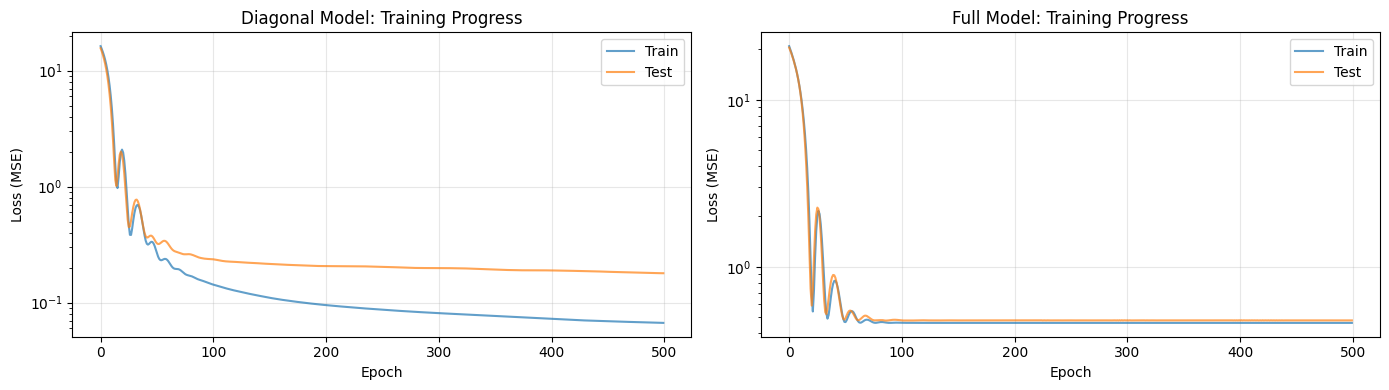

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Diagonal model loss
axes[0].plot(diag_train_loss, label='Train', alpha=0.7)
axes[0].plot(diag_test_loss, label='Test', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Diagonal Model: Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Full model loss
axes[1].plot(full_train_loss, label='Train', alpha=0.7)
axes[1].plot(full_test_loss, label='Test', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].set_title('Full Model: Training Progress')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

## Visualization: Singular Value Spectra Evolution - Diagonal Model

Plot how singular values of each weight matrix evolve during training for the diagonal architecture.

In [10]:
def plot_spectra_evolution(spectra_history, epochs_recorded, title_prefix):
    """
    Plot singular value spectra evolution over training
    
    Args:
        spectra_history: Dict mapping block names to list of spectra
        epochs_recorded: List of epochs when spectra were recorded
        title_prefix: Prefix for plot titles
    """
    # Filter out empty spectra
    filtered_history = {name: spectra for name, spectra in spectra_history.items() 
                       if len(spectra) > 0}
    
    if len(filtered_history) == 0:
        print(f"No spectra data to plot for {title_prefix}")
        return
    
    n_blocks = len(filtered_history)
    fig, axes = plt.subplots(1, n_blocks, figsize=(5*n_blocks, 4))
    
    # Always convert to list for consistent indexing
    if n_blocks == 1:
        axes = [axes]
    else:
        axes = list(axes)
    
    for idx, (name, spectra_list) in enumerate(filtered_history.items()):
        ax = axes[idx]
        
        # Plot spectra at different epochs with colormap
        n_snapshots = len(spectra_list)
        colors = plt.cm.viridis(np.linspace(0, 1, n_snapshots))
        
        for i, (spectrum, epoch) in enumerate(zip(spectra_list, epochs_recorded)):
            ax.plot(spectrum, color=colors[i], alpha=0.7, linewidth=1.5)
        
        ax.set_xlabel('Singular Value Index')
        ax.set_ylabel('Singular Value')
        ax.set_title(f'{title_prefix} - {name}')
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        
        # Add colorbar to show epoch progression
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                   norm=plt.Normalize(vmin=epochs_recorded[0], 
                                                     vmax=epochs_recorded[-1]))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Epoch')
    
    plt.tight_layout()
    plt.show()

# Plot diagonal model spectra
plot_spectra_evolution(diag_spectra, diag_epochs, "Diagonal Model")

No spectra data to plot for Diagonal Model


## Visualization: Singular Value Spectra Evolution - Full Model

Plot spectra for selected blocks from the full architecture (plotting all blocks would be too cluttered).

In [11]:
# Select a subset of blocks to visualize from full model
# First, see what blocks we actually have
print(f"Available blocks: {list(full_spectra.keys())}")

# Select blocks that actually exist
desired_blocks = ['G01', 'G12', 'G23']
selected_blocks = [b for b in desired_blocks if b in full_spectra]
selected_spectra = {k: v for k, v in full_spectra.items() if k in selected_blocks}

print(f"Selected blocks for visualization: {selected_blocks}")
plot_spectra_evolution(selected_spectra, full_epochs, "Full Model (Selected Blocks)")

Available blocks: ['G01', 'G02', 'G03', 'G12', 'G13', 'G23']
Selected blocks for visualization: ['G01', 'G12', 'G23']
No spectra data to plot for Full Model (Selected Blocks)


## Visualization: Heatmap of Singular Value Decay

Show how singular values decay across indices for each block at the final epoch.

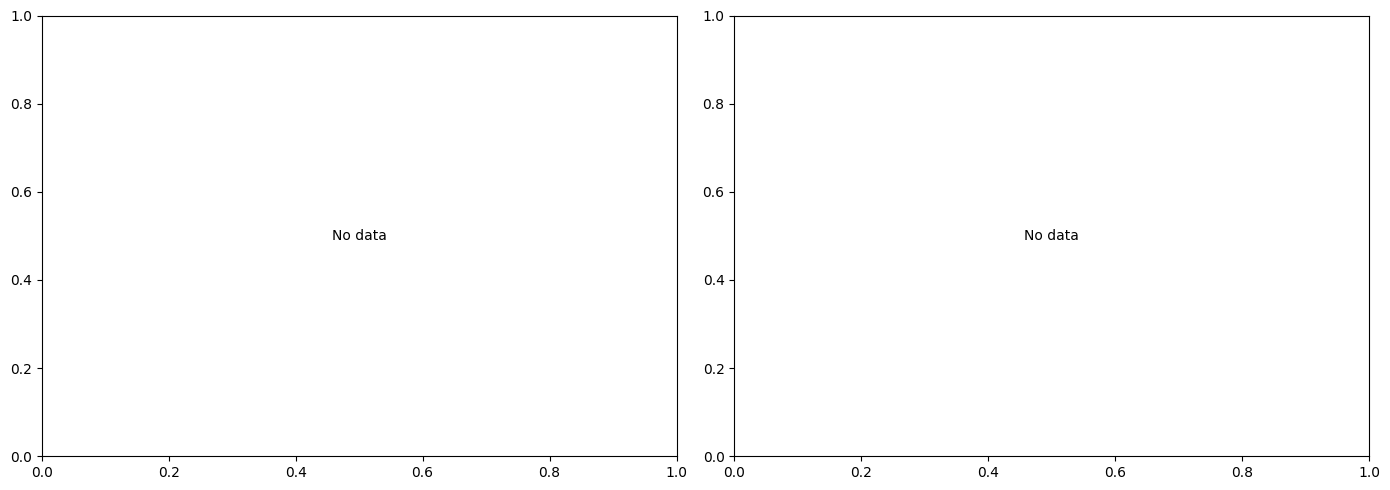

In [12]:
def plot_final_spectra_comparison(diag_spectra, full_spectra, selected_full_blocks):
    """
    Compare final singular value spectra between models
    
    Args:
        diag_spectra: Spectra history for diagonal model
        full_spectra: Spectra history for full model  
        selected_full_blocks: List of block names to show from full model
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Diagonal model - final spectra
    ax = axes[0]
    diag_plotted = False
    for name, spectra_list in diag_spectra.items():
        if len(spectra_list) > 0:
            final_spectrum = spectra_list[-1]
            ax.plot(final_spectrum, marker='o', label=name, linewidth=2, markersize=4)
            diag_plotted = True
    
    if diag_plotted:
        ax.set_xlabel('Singular Value Index')
        ax.set_ylabel('Singular Value')
        ax.set_title('Diagonal Model - Final Spectra')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
    
    # Full model - final spectra for selected blocks
    ax = axes[1]
    full_plotted = False
    for name in selected_full_blocks:
        if name in full_spectra and len(full_spectra[name]) > 0:
            final_spectrum = full_spectra[name][-1]
            ax.plot(final_spectrum, marker='o', label=name, linewidth=2, markersize=4)
            full_plotted = True
    
    if full_plotted:
        ax.set_xlabel('Singular Value Index')
        ax.set_ylabel('Singular Value')
        ax.set_title('Full Model - Final Spectra (Selected Blocks)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

plot_final_spectra_comparison(diag_spectra, full_spectra, selected_blocks)

## Analysis: Spectral Properties Over Time

Track key spectral properties: condition number, effective rank, and spectral decay rate.

In [13]:
def compute_spectral_metrics(spectra_history):
    """
    Compute spectral metrics over training
    
    Args:
        spectra_history: Dict mapping block names to list of spectra
        
    Returns:
        metrics: Dict mapping block names to dict of metric lists
    """
    metrics = {}
    
    for name, spectra_list in spectra_history.items():
        if len(spectra_list) == 0:
            continue
            
        condition_numbers = []
        effective_ranks = []
        spectral_gaps = []
        
        for spectrum in spectra_list:
            # Condition number: ratio of largest to smallest singular value
            if spectrum[-1] > 1e-10:  # Avoid division by zero
                condition_numbers.append(spectrum[0] / spectrum[-1])
            else:
                condition_numbers.append(np.inf)
            
            # Effective rank: number of singular values > threshold
            threshold = 0.01 * spectrum[0]
            effective_ranks.append(np.sum(spectrum > threshold))
            
            # Spectral gap: ratio of first to second singular value
            if len(spectrum) > 1:
                spectral_gaps.append(spectrum[0] / spectrum[1])
            else:
                spectral_gaps.append(1.0)
        
        metrics[name] = {
            'condition_number': condition_numbers,
            'effective_rank': effective_ranks,
            'spectral_gap': spectral_gaps
        }
    
    return metrics

# Compute metrics
diag_metrics = compute_spectral_metrics(diag_spectra)
full_metrics = compute_spectral_metrics({k: v for k, v in full_spectra.items() if k in selected_blocks})

/tmp/ipykernel_154866/1442362126.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/tmp/ipykernel_154866/1442362126.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/tmp/ipykernel_154866/1442362126.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


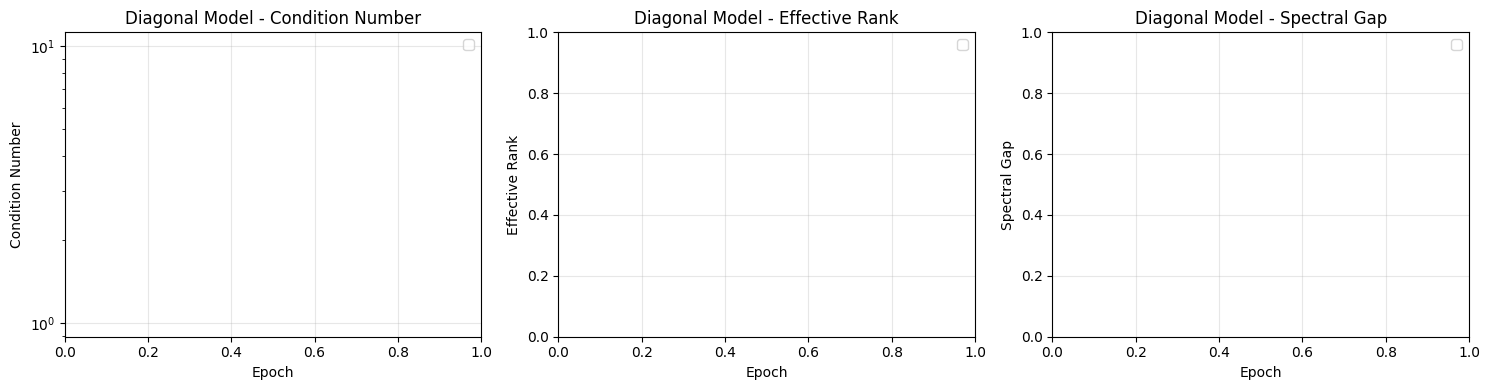

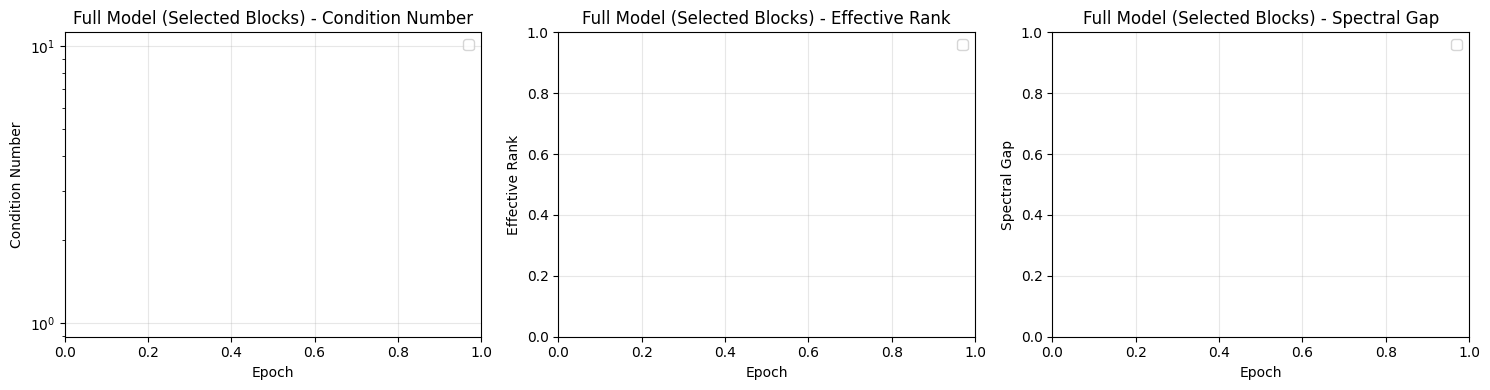

In [14]:
def plot_spectral_metrics(metrics, epochs_recorded, title_prefix):
    """
    Plot spectral metrics over training
    
    Args:
        metrics: Dict of metrics from compute_spectral_metrics
        epochs_recorded: List of epochs
        title_prefix: Prefix for titles
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for name, metric_dict in metrics.items():
        axes[0].plot(epochs_recorded, metric_dict['condition_number'], 
                    marker='o', label=name, linewidth=2, markersize=4)
        axes[1].plot(epochs_recorded, metric_dict['effective_rank'], 
                    marker='o', label=name, linewidth=2, markersize=4)
        axes[2].plot(epochs_recorded, metric_dict['spectral_gap'], 
                    marker='o', label=name, linewidth=2, markersize=4)
    
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Condition Number')
    axes[0].set_title(f'{title_prefix} - Condition Number')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_yscale('log')
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Effective Rank')
    axes[1].set_title(f'{title_prefix} - Effective Rank')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Spectral Gap')
    axes[2].set_title(f'{title_prefix} - Spectral Gap')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot metrics for both models
plot_spectral_metrics(diag_metrics, diag_epochs, "Diagonal Model")
plot_spectral_metrics(full_metrics, full_epochs, "Full Model (Selected Blocks)")

## Summary and Observations

### Key Questions to Explore:

1. **Spectral Decay**: How do singular values decay during training? Do they follow a power law?

2. **Conditioning**: Does the condition number increase or decrease during training? What does this tell us about the stability of the learned transformation?

3. **Effective Rank**: Does the effective rank change during training? This indicates whether the transformation is learning to use all available dimensions.

4. **Architecture Differences**: How do the spectral properties differ between the diagonal (sequential) and full (parallel paths) architectures?

5. **Learning Dynamics**: Do singular values change rapidly early in training and then stabilize? Or do they continue to evolve throughout training?

### Directions for Further Exploration:

- Try different problem types (classification vs regression)
- Vary the hidden layer size relative to input size
- Use different activation functions
- Compare with standard Sequential models (non-block structure)
- Analyze the relationship between spectral properties and generalization performance